# ECE176: Pneumonia Detection, CNN

## Introduction

**In this report, we aim to address the following questions:**

1. How accurately can we distinguish healthy and pneumonia patients with our CNN? 

2. Can we distinguish between viral and bacterial pneumonia? 
       
3. Can we use pre-trained CNNs or UNET models to create a more accurate model? 

## Dataset

[Collection of Chest X Ray of Healthy vs Pneumonia affected patients](https://www.kaggle.com/datasets/praveengovi/coronahack-chest-xraydataset)

## Import Packages and Prepare GPU

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torch.nn.functional as F

import torchvision.datasets as dset
import torchvision.transforms as T
import torchvision
from torch.optim import Adam, lr_scheduler
import numpy as np
import os
import pandas as pd
import shutil
import matplotlib.pyplot as plt

In [2]:
USE_GPU = True
num_class = 100
dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cuda


## Load Dataset With Augmentations

We first need to split the images based on labeled classes to use the Dataloader.

**Note: This only needs to be run one time**

In [3]:
# first read in the metadata file
data = pd.read_csv("Chest_xray_Corona_Metadata.csv")
data.head(10)

,Unnamed: 0,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
0,0,IM-0128-0001.jpeg,Normal,TRAIN,NaN,NaN
1,1,IM-0127-0001.jpeg,Normal,TRAIN,NaN,NaN
2,2,IM-0125-0001.jpeg,Normal,TRAIN,NaN,NaN
3,3,IM-0122-0001.jpeg,Normal,TRAIN,NaN,NaN
4,4,IM-0119-0001.jpeg,Normal,TRAIN,NaN,NaN
5,5,IM-0117-0001.jpeg,Normal,TRAIN,NaN,NaN
6,6,IM-0115-0001.jpeg,Normal,TRAIN,NaN,NaN
7,7,IM-0189-0001.jpeg,Normal,TRAIN,NaN,NaN
8,8,IM-0187-0001.jpeg,Normal,TRAIN,NaN,NaN
9,9,IM-0185-0001.jpeg,Normal,TRAIN,NaN,NaN


In [4]:
print(set(data['Label']))

{'Normal', 'Pnemonia'}


In [5]:
# subdirectories for each class
#os.mkdir("Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/Pnemonia")
#os.mkdir("Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/Normal")
#os.mkdir("Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/test/Pnemonia")
#os.mkdir("Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/test/Normal")

In [6]:
path_train = "Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train"
path_test = "Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/test"

train_num = len(os.listdir(path_train))
print("Train data: " + str(train_num))
test_num = len(os.listdir(path_test))
print("Test data: " + str(test_num))


Train data: 5311
Test data: 626


In [7]:
# ONLY NEED TO RUN ONCE

normal_train = 0
pnemonia_train = 0
normal_test = 0
pnemonia_test = 0

# "X_ray_image_name" = name of file
# "Label" = pneumonia or normal
# "Dataset_type" = train or test

for i in range(data.shape[0]):
    if data["Dataset_type"][i] == "TRAIN":
        if data["Label"][i] == "Normal":
            shutil.copy(path_train + "/" + data["X_ray_image_name"][i], path_train + "/Normal/" + data["X_ray_image_name"][i])
            normal_train = normal_train + 1
        else:
            shutil.copy(path_train + "/" + data["X_ray_image_name"][i], path_train + "/Pnemonia/" + data["X_ray_image_name"][i])
            pnemonia_train = pnemonia_train + 1
    elif data["Dataset_type"][i] == "TEST":
        if data["Label"][i] == "Normal":
            shutil.copy(path_test + "/" + data["X_ray_image_name"][i], path_test + "/Normal/" + data["X_ray_image_name"][i])
            normal_test = normal_test + 1
        else:
            shutil.copy(path_test + "/" + data["X_ray_image_name"][i], path_test + "/Pnemonia/" + data["X_ray_image_name"][i])
            pnemonia_test = pnemonia_test + 1

print(
    "X-ray of Normal patients (TRAIN DATASET): " + str(normal_train) + "\n",
    "X-ray of Infected patients (TRAIN DATASET): " + str(pnemonia_train) + "\n",
    "X-ray of Normal patients (TEST DATASET): " + str(normal_test) + "\n",
    "X-ray of Infected patients (TEST DATASET): " + str(pnemonia_test) + "\n"
)

X-ray of Normal patients (TRAIN DATASET): 1342
 X-ray of Infected patients (TRAIN DATASET): 3944
 X-ray of Normal patients (TEST DATASET): 234
 X-ray of Infected patients (TEST DATASET): 390



In [8]:
# redefine number of train test 
train_num = normal_train + pnemonia_train
print("Train data: " + str(train_num))
test_num = normal_test + pnemonia_test
print("Test data: " + str(test_num))

Train data: 5286
Test data: 624


In [9]:
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets as dset
from torchvision import transforms as T
from torch.utils.data import sampler

train_data_path = "Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/"
test_data_path = "Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/test/"
batch_size = 16

# Data augmentation
transform = T.Compose([
    T.Resize(256),
    T.RandomHorizontalFlip(),  # Horizontal flips
    T.CenterCrop(256),  # Crops
    T.ToTensor(),
    T.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))  # Hard coded mean and std rgb values
])

# Load the datasets
full_train_data = dset.ImageFolder(root=train_data_path, transform=transform)

# Splitting the dataset
train_size = int(0.8 * len(full_train_data))
val_size = len(full_train_data) - train_size
train_dataset, val_dataset = random_split(full_train_data, [train_size, val_size])

# Data loaders
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_data_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_data = dset.ImageFolder(root=test_data_path, transform=transform)
test_data_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=2)


# Visualize Data

### Counting the number of images in each class

In this dataset, we categorize the images into two classes: 'Normal' and 'Pneumonia.' In the plot below, 'Normal' instances are colored red, while 'Pneumonia' cases are green.

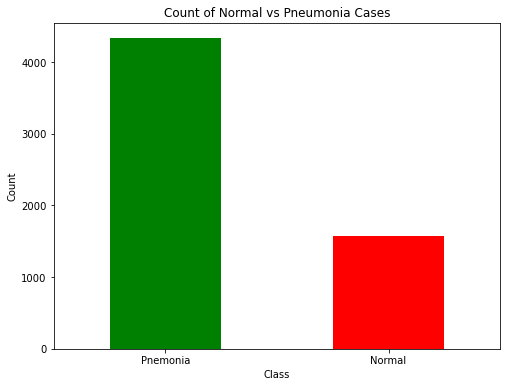

Label
Pnemonia    4334
Normal      1576
Name: count, dtype: int64


In [10]:
# Count number of images in each class
class_counts = data['Label'].value_counts()

# Specify colors for each class
colors = ['red' if label == 'Normal' else 'green' for label in class_counts.index]

# Plotting
plt.figure(figsize=(8, 6))
class_counts.plot(kind='bar', color=colors)
plt.title('Count of Normal vs Pneumonia Cases')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=0)  # Keep the class names horizontal for readability
plt.show()
print(class_counts)

It is important for us to make sure that our training and testing folds have similar ratios of normal and pneumonia images.

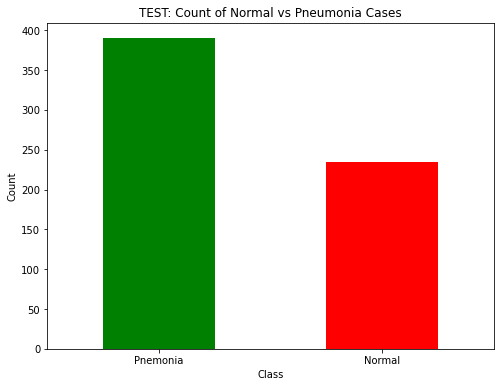

Label
Pnemonia    390
Normal      234
Name: count, dtype: int64


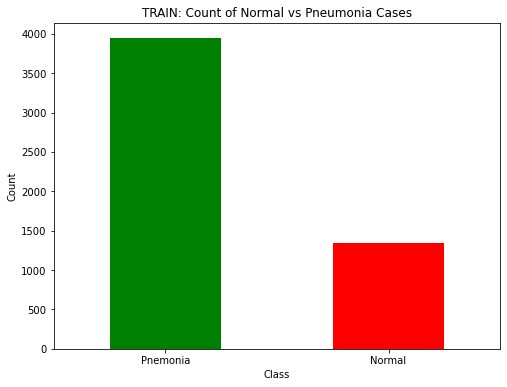

Label
Pnemonia    3944
Normal      1342
Name: count, dtype: int64


In [11]:
train_test_grouped = data.groupby('Dataset_type')

for name, group in train_test_grouped:
    # Count number of images in each class
    class_counts = group['Label'].value_counts()

    # Specify colors for each class
    colors = ['red' if label == 'Normal' else 'green' for label in class_counts.index]

    # Plotting
    plt.figure(figsize=(8, 6))
    class_counts.plot(kind='bar', color=colors)
    plt.title( name + ': Count of Normal vs Pneumonia Cases')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.xticks(rotation=0)  # Keep the class names horizontal for readability
    plt.show()
    print(class_counts)

> This shows that our model will be training and testing on similar ratios of case and control images.

### Visualizing the chest X-rays

In [12]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5071, 0.4867, 0.4408])
    std = np.array([0.2675, 0.2565, 0.2761])
    inp = std * inp + mean  # unnormalize
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(10, 5))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


Visualizing the input images from the training data:

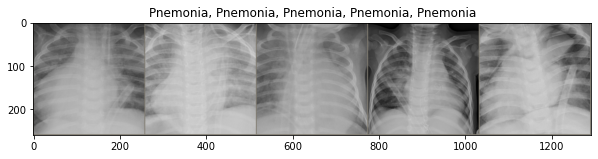

In [13]:
import torchvision

# Load a batch of images and their corresponding labels from the train_data_loader
batch_images, batch_labels = next(iter(train_data_loader))

# Randomly select a subset of data from the loaded batch
num_samples = 5  # Define how many samples you want to visualize
random_indices = torch.randperm(len(batch_images))[:num_samples]  # Get random indices
selected_images = batch_images[random_indices]
selected_labels = batch_labels[random_indices]

# Create a grid layout for the selected images
image_grid = torchvision.utils.make_grid(selected_images)

# Generate titles (labels) for the selected images
label_titles = ', '.join([full_train_data.classes[label] for label in selected_labels])

# Display the images and their titles
imshow(image_grid, title=label_titles)


Visualizing the input images from the testing data:

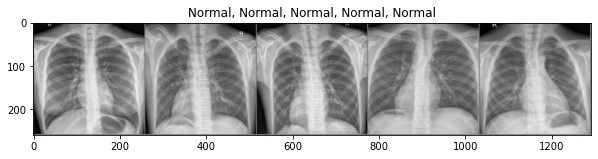

In [14]:
import torchvision

# Load a batch of images and their corresponding labels from the train_data_loader
batch_images, batch_labels = next(iter(test_data_loader))

# Randomly select a subset of data from the loaded batch
num_samples = 5  # Define how many samples you want to visualize
random_indices = torch.randperm(len(batch_images))[:num_samples]  # Get random indices
selected_images = batch_images[random_indices]
selected_labels = batch_labels[random_indices]

# Create a grid layout for the selected images
image_grid = torchvision.utils.make_grid(selected_images)

# Generate titles (labels) for the selected images
label_titles = ', '.join([full_train_data.classes[label] for label in selected_labels])

# Display the images and their titles
imshow(image_grid, title=label_titles)


> In this section, we visualized 5 random images from the training and testing set. We can see that the inflammation of the lungs is visible in these chest X-rays for patients with pneumonia. 

# Define Training and Testing functions

In [15]:
def flatten(x):
    N = x.shape[0] 
    return x.view(N, -1)

In [16]:
# create a function for model testing 

def check_accuracy(loader, model):
    # loader should be the test_data_loader
    print('Checking accuracy on test set')
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device=device, dtype=dtype), y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
    return acc

In [17]:
def train_test_model(model, train_data_loader, val_data_loader, test_data_loader, optimizer, epochs=10, print_every=50, device='cuda', use_early_stop=True, patience=5, use_scheduler=False):
    """
    Train and test a model, with optional early stopping based on validation accuracy and optional learning rate scheduling.
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - train_data_loader: Data loader for the training set.
    - val_data_loader: Data loader for the validation set.
    - test_data_loader: Data loader for the test set.
    - optimizer: An Optimizer object we will use to train the model.
    - epochs: (Optional) Number of epochs to train the model.
    - print_every: (Optional) Number of iterations before printing loss and checking accuracy.
    - device: (Optional) Device to run the model on ('cuda' or 'cpu').
    - use_early_stop: (Optional) Whether to use early stopping.
    - patience: (Optional) Number of epochs to wait for improvement before stopping.
    - use_scheduler: (Optional) Whether to use learning rate scheduler.
    
    Returns: A tuple of lists containing training, validation, and test accuracies at each print iteration.
    """
    train_accuracies, val_accuracies, test_accuracies = [], [], []
    best_val_acc = 0
    epochs_no_improve = 0
    
    # Initialize scheduler if use_scheduler is True
    scheduler = None
    if use_scheduler:
        scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    for e in range(epochs):
        model.train()  # Set model to training mode
        for t, (x, y) in enumerate(train_data_loader):
            x, y = x.to(device=device), y.to(device=device, dtype=torch.long)

            # Forward pass
            scores = model(x)
            loss = F.cross_entropy(scores, y)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if (t + 1) % print_every == 0:
                print(f'Epoch {e}, Iteration {t + 1}, loss = {loss.item():.4f}')
                # Check accuracy on the training set
                train_acc = check_accuracy(train_data_loader, model)
                train_accuracies.append(train_acc)
                
                # Check accuracy on the validation set
                val_acc = check_accuracy(val_data_loader, model)
                val_accuracies.append(val_acc)
                
                test_acc = check_accuracy(test_data_loader, model)
                test_accuracies.append(test_acc)
                # Early stopping logic
                if use_early_stop:
                    if val_acc > best_val_acc:
                        best_val_acc = val_acc
                        epochs_no_improve = 0
                    else:
                        epochs_no_improve += 1
                        if epochs_no_improve == patience:
                            print(f'Early stopping triggered after {e+1} epochs.')
                            return train_accuracies, val_accuracies, test_accuracies
                print(f'Training Accuracy: {train_acc:.2f}, Validation Accuracy: {val_acc:.2f}')
        
        # Learning rate scheduler step
        if use_scheduler and scheduler is not None:
            scheduler.step()

    # Final testing accuracy after all epochs
    print("Final Test Accuracy")
    final_test_acc = check_accuracy(test_data_loader, model)
    print(f'Final Test Accuracy: {final_test_acc:.2f}')
    
    return train_accuracies, val_accuracies, test_accuracies

# Simple CNN

### Defining the simple CNN architecture

In [18]:
# # Define the CNN architecture
# class PneumoniaSimpleCNN(nn.Module):
#     def __init__(self, num_classes=2):  # 2 classes: Normal, Pneumonia
#         super(PneumoniaSimpleCNN, self).__init__()
#         # Define layers of a CNN
#         self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)  
#         self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        
#         self.fc1 = nn.Linear(64 * 64 * 64, 128)  # Decreased from 512 to 256
#         self.fc2 = nn.Linear(128, num_classes)  # Adjusted accordingly
        
#         self.relu = nn.ReLU()
#         self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
#     def forward(self, x):
        
#         x = self.pool(self.relu(self.conv1(x)))
#         x = self.pool(self.relu(self.conv2(x)))
#         # Flatten the layer
#         x = flatten(x)
#         x = self.relu(self.fc1(x))
#         x = self.fc2(x)
#         return x

### Train and Test the Simple CNN model

In [19]:
# num_classes = 2  # Normal, Pneumonia
# learning_rate = 0.001
# num_epochs = 10
# from torch.optim import lr_scheduler

# # Define the model 
# model = PneumoniaSimpleCNN(num_classes).to(device)

# # Optimizer
# optimizer = optim.Adam(model.parameters(), lr=learning_rate,weight_decay=1e-4)

# # Train the model
# train_accuracies, val_accuracies, test_accuracies = train_test_model(model,
#                                                      train_data_loader,
#                                                      val_data_loader, test_data_loader, 
#                                                      optimizer, 
#                                                      epochs=10,
#                                                      print_every=50,
#                                                      device='cuda',
#                                                      use_early_stop=True,
#                                                      patience=5, 
#                                                      use_scheduler=True)

### Visualize the image, true labels, and predicted labels

In [20]:
# def imshow(img):
#     img = img.cpu().numpy().transpose((1, 2, 0))  # convert from Tensor image
#     mean = np.array([0.485, 0.456, 0.406])
#     std = np.array([0.229, 0.224, 0.225])
#     img = std * img + mean  # Unnormalize
#     img = np.clip(img, 0, 1)  # Clip values to [0, 1] range
#     plt.imshow(img)
#     plt.show()

# # Assuming test_data_loader has batch_size at least 5 or adjust as necessary
# # Get a batch of test images and labels
# dataiter = iter(test_data_loader)
# images, labels = next(dataiter)

# # Select random 5 indices
# idx = np.random.choice(images.size(0), 5, replace=False)

# # Select random images and labels
# random_images = images[idx]
# random_labels = labels[idx]

# # Move tensors to the configured device
# random_images, random_labels = random_images.to(device), random_labels.to(device)

# # Get predictions
# model.eval()  # Make sure model is in eval mode
# with torch.no_grad():
#     outputs = model(random_images)
#     _, predicted = torch.max(outputs, 1)

# # Show images
# imshow(torchvision.utils.make_grid(random_images.cpu()))
# # Print true and predicted labels
# print('True labels: ', ' '.join(f'{test_data.classes[random_labels[j].item()]}' for j in range(len(random_labels))))
# print('Predicted: ', ' '.join(f'{test_data.classes[predicted[j].item()]}' for j in range(len(predicted))))

### Visualize accuracy over epochs 

In [21]:

# actual_epochs = len(train_accuracies)  # Assuming this reflects the actual number of epochs run
# epochs = list(range(1, actual_epochs + 1))

# # Now, we'll plot the accuracies.
# plt.figure(figsize=[10,5])
# plt.plot(epochs, train_accuracies, label='Training Accuracy', marker='o')
# plt.plot(epochs, val_accuracies, label='Validation Accuracy', marker='o')
# plt.plot(epochs, test_accuracies, label='Testing Accuracy', marker='o')
# plt.title('Model Accuracies per Epoch')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.grid(True)
# plt.show()


> Note: This accuracy of 78% is not that impressive when we consider the ratio of the number of pneumonia and normal images in the testing set. This is because simply predicting Pnemonia for every image will result in a 62.5% accuracy. 

# Resnet CNN

### Can Resnet CNN be applied to classify chest X-rays?

### Define the Resnet Architecture

In [22]:
# class ResNetBlocks(nn.Module):
#     def __init__(self, in_channels, out_channels, stride=1, downsample=None, batchnorm=True):
#         super(ResNetBlocks, self).__init__()
        
#         self.downsample = downsample
#         self.relu = nn.ReLU(inplace=True) #relu
#         self.out_channels = out_channels
        
#         self.conv_1 = nn.Sequential(
#             nn.Conv2d(in_channels, out_channels, (3,3), stride=stride, padding = 1),
#             nn.ReLU(inplace=True)
#         )
#         if batchnorm:
#             self.conv_1 = nn.Sequential(
#                 nn.Conv2d(in_channels, out_channels, (3,3), stride=stride, padding = 1), 
#                 nn.BatchNorm2d(out_channels),
#                 nn.ReLU(inplace=True)
#                 )
        
#         self.conv_2 = nn.Sequential(
#             nn.Conv2d(out_channels, out_channels, (3,3), stride=1, padding = 1)
#         )
#         if batchnorm:
#             self.conv_2 = nn.Sequential(
#                 nn.Conv2d(out_channels, out_channels, (3,3), stride=1, padding = 1), 
#                 nn.BatchNorm2d(out_channels)
#             )
        
#     def forward(self, x):
#         resid=x
#         out = self.conv_1(x)
#         out = self.conv_2(out)
#         if self.downsample:
#             resid=self.downsample(x)
#         out = out + resid
#         out = self.relu(out)
#         return out
        
    
# class ResNet(nn.Module):
    
#     def __init__(self, block, num_blocks, batchnorm=True):
#         super(ResNet, self).__init__()
        
#         self.inchannel=64 # current channel size, used later for skips 
        
#         self.convlayer_1 = nn.Sequential(
#             nn.Conv2d(3, 64, (7,7), stride=2, padding=3),
#             nn.ReLU(inplace=True)
#         )
        
#         if batchnorm:
#             self.convlayer_1 = nn.Sequential(
#                 nn.Conv2d(3, 64, (7,7), stride=2, padding=3),
#                 nn.BatchNorm2d(64),
#                 nn.ReLU(inplace=True)
#             )
        
#         self.maxpool = nn.MaxPool2d((3,3), stride=2, padding = 1)
        
#         self.block1 = self.make_layer(block, 64, num_blocks[0], stride = 1)
#         self.block2 = self.make_layer(block, 128, num_blocks[1], stride = 1)
#         self.block3 = self.make_layer(block, 256, num_blocks[2], stride = 1)
#         self.block4 = self.make_layer(block, 512, num_blocks[3], stride = 2)
        
#         self.avgpool = nn.AdaptiveAvgPool2d((1,1))
#         self.fc = nn.Linear( 512, num_class) 
#         #nn.init.kaiming_normal_(self.fc.weight)
    
#     def make_layer(self, block, channel, numblocks, stride=1, batchnorm=True):
#         downsample = None
#         if self.inchannel != channel:
#             downsample = nn.Sequential(
#                 nn.Conv2d(self.inchannel, channel, (1,1), stride=stride) # add skip arrow
#             )
#             if batchnorm:
#                 downsample = nn.Sequential(
#                     nn.Conv2d(self.inchannel, channel, (1,1), stride=stride), # add skip arrow
#                     nn.BatchNorm2d(channel)
#                 )
            
#         layers = []
#         layers.append(block(self.inchannel, channel, stride, downsample))
#         self.inchannel = channel #update current channel
        
#         # add number of blocks here 
#         for j in range(1,numblocks): # if we want to add 2 blocks, this for loop will run once 
#             layers.append(block(self.inchannel, channel))
            
#         return nn.Sequential(*layers)
    
        
#     def forward(self, x):
#         x = self.convlayer_1(x)
#         x = self.maxpool(x)
#         x = self.block1(x)
#         x = self.block2(x)
#         x = self.block3(x)
#         x = self.block4(x)
#         x = self.avgpool(x)
#         x = flatten(x)
#         x = self.fc(x)
#         return x

### Train and Test the model

In [23]:
# num_classes = 2  # Normal, Pneumonia
# learning_rate = 0.001
# num_epochs = 10

# # Define the model 
# model = ResNet(ResNetBlocks, [2,2,2,2]).to(device)

# # Optimizer
# optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# # Train the model
# train_accuracies, val_accuracies, test_accuracies = train_test_model(model,
#                                                      train_data_loader,
#                                                      val_data_loader, test_data_loader, 
#                                                      optimizer, 
#                                                      epochs=10,
#                                                      print_every=50,
#                                                      device='cuda',
#                                                      use_early_stop=True,
#                                                      patience=5, 
#                                                      use_scheduler=False)

### Visualize the Accuracy Over Epochs

In [24]:

# actual_epochs = len(train_accuracies)  # Assuming this reflects the actual number of epochs run
# epochs = list(range(1, actual_epochs + 1))

# # Now, we'll plot the accuracies.
# plt.figure(figsize=[10,5])
# plt.plot(epochs, train_accuracies, label='Training Accuracy', marker='o')
# plt.plot(epochs, val_accuracies, label='Validation Accuracy', marker='o')
# plt.plot(epochs, test_accuracies, label='Testing Accuracy', marker='o')
# plt.title('Model Accuracies per Epoch')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.grid(True)
# plt.show()

In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets as dset
from torchvision import transforms as T
from torch.optim import Adam, lr_scheduler
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import shutil

# Using the device
USE_GPU = True
device = torch.device('cuda' if USE_GPU and torch.cuda.is_available() else 'cpu')
print('Using device:', device)

# UNet model adapted for classification
class UNet(nn.Module):
    def __init__(self, n_class):
        super(UNet, self).__init__()
        self.n_class = n_class
        
        # Contracting Path (Encoder)
        self.enc_conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.enc_conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.enc_conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.enc_conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.enc_conv5 = nn.Conv2d(512, 1024, kernel_size=3, padding=1)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Expansive Path (Decoder)
        self.dec_conv1 = nn.Conv2d(1024, 512, kernel_size=3, padding=1)
        self.dec_conv2 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.dec_conv3 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.dec_conv4 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        
        self.upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.upconv4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))  # Global average pooling layer
        
        self.final_conv = nn.Conv2d(64, n_class, kernel_size=1)  # Adjusted for classification
        
    def forward(self, x):
        # Contracting Path
        enc1 = F.relu(self.enc_conv1(x))
        enc2 = F.relu(self.enc_conv2(self.pool(enc1)))
        enc3 = F.relu(self.enc_conv3(self.pool(enc2)))
        enc4 = F.relu(self.enc_conv4(self.pool(enc3)))
        enc5 = F.relu(self.enc_conv5(self.pool(enc4)))
        
        # Expansive Path
        dec1 = F.relu(self.dec_conv1(torch.cat((self.upconv1(enc5), enc4), dim=1)))
        dec2 = F.relu(self.dec_conv2(torch.cat((self.upconv2(dec1), enc3), dim=1)))
        dec3 = F.relu(self.dec_conv3(torch.cat((self.upconv3(dec2), enc2), dim=1)))
        dec4 = F.relu(self.dec_conv4(torch.cat((self.upconv4(dec3), enc1), dim=1)))
        
        dec4 = self.global_avg_pool(dec4)  
        output = self.final_conv(dec4)  
        output = output.view(output.size(0), -1) 
        return output

# Define model, optimizer, and loss function
model = UNet(n_class=2).to(device)  # Assuming 2 classes: Normal and Pneumonia
optimizer = Adam(model.parameters(), lr=0.001, weight_decay=1e-4)


Using device: cuda


In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
learning_rate = 0.001
num_epochs = 10
from torch.optim import lr_scheduler

model = UNet(2)  # Specify your number of classes
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# Train the model
train_accuracies, val_accuracies, test_accuracies = train_test_model(model,
                                                     train_data_loader,
                                                     val_data_loader, test_data_loader, 
                                                     optimizer, 
                                                     epochs=10,
                                                     print_every=50,
                                                     device='cuda',
                                                     use_early_stop=True,
                                                     patience=10, 
                                                     use_scheduler=True)

Epoch 0, Iteration 50, loss = 0.5385
Checking accuracy on test set
Got 3111 / 4228 correct (73.58)
Checking accuracy on test set
Got 774 / 1058 correct (73.16)
Checking accuracy on test set
Got 383 / 624 correct (61.38)
Training Accuracy: 0.74, Validation Accuracy: 0.73
Epoch 0, Iteration 100, loss = 0.6400
Checking accuracy on test set
Got 3164 / 4228 correct (74.83)
Checking accuracy on test set
Got 780 / 1058 correct (73.72)
Checking accuracy on test set
Got 389 / 624 correct (62.34)
Training Accuracy: 0.75, Validation Accuracy: 0.74
Epoch 0, Iteration 150, loss = 0.7089
Checking accuracy on test set
Got 3148 / 4228 correct (74.46)
Checking accuracy on test set
Got 779 / 1058 correct (73.63)
Checking accuracy on test set
Got 388 / 624 correct (62.18)
Training Accuracy: 0.74, Validation Accuracy: 0.74
Epoch 0, Iteration 200, loss = 0.5717
Checking accuracy on test set
Got 3164 / 4228 correct (74.83)
Checking accuracy on test set
Got 781 / 1058 correct (73.82)
Checking accuracy on tes

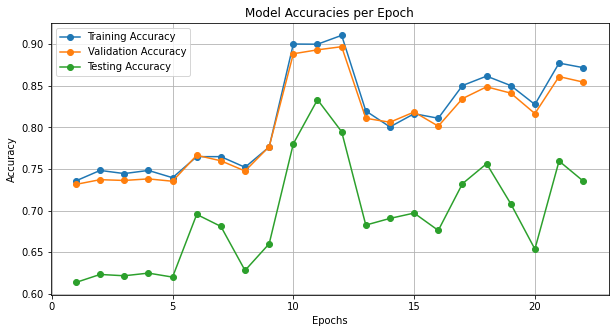

In [29]:

actual_epochs = len(train_accuracies)  # Assuming this reflects the actual number of epochs run
epochs = list(range(1, actual_epochs + 1))

# Now, we'll plot the accuracies.
plt.figure(figsize=[10,5])
plt.plot(epochs, train_accuracies, label='Training Accuracy', marker='o')
plt.plot(epochs, val_accuracies, label='Validation Accuracy', marker='o')
plt.plot(epochs, test_accuracies, label='Testing Accuracy', marker='o')
plt.title('Model Accuracies per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

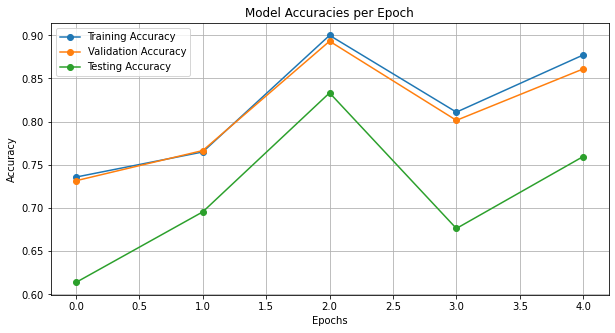

In [31]:

actual_epochs = len(train_accuracies)  # Assuming this reflects the actual number of epochs run
epochs = list(range(0, 5))

# Now, we'll plot the accuracies.
plt.figure(figsize=[10,5])
plt.plot(epochs, train_accuracies[0::5], label='Training Accuracy', marker='o')
plt.plot(epochs, val_accuracies[0::5], label='Validation Accuracy', marker='o')
plt.plot(epochs, test_accuracies[0::5], label='Testing Accuracy', marker='o')
plt.title('Model Accuracies per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()